# Airbnb ROI Predictor Model

## Introduction

<p>We're Fady and Hedva, computer science students passionate about data science. We wanted to choose a problem that We're passionate about and interests us. therefore We chose investment in real estate abroad.</p>

<p>In recent years, many Israelis have been investing in real estate abroad (especially in Europe) since the prices are attractive, and could make an attractive ROI in many places.
Some choose to rent out the property with traditional long-term rent, and some decide to list it on Airbnb, hoping to outperform traditional renting methods.</p>

<p>Therefore it would be an interesting project to analyze data for property prices and Airbnb rent costs and build a model that predicts the ROI for listing a property on Airbnb.</p>

<p>The idea is to build a model consisting of 2 sub-models. 
    The first model will predict for a given property the average rent cost per night (there will be distinction between weekdays and weekends) and we'll refer to this model with M1.
The second model will predict the property price for a given property, we'll refer to this model with M2.
Together from the output of the 2 models, we can calculate the ROI (How many years it will take to return the money invested in the property).</p>

<p>The model will be also capable of considering the capital gain tax on real estate, and the interest rate in case the buyer takes a mortgage.</p>

<h4>Couple of notes:</h4>
    <ul>
        <li>We didn't find a dataset with the number of rent days per year, therefore we decided to assume the number of rent days per year, and this number will be a global variable that can be configured</li>
        <li>The capital gain tax will be a global variable that can be configured, it will be set to Israel's capital gain tax value</li>
        <li>The annual interest rate will be a global variable that can be configured, it will be set to Israel's average annual interest rate</li>
        <li>In this project, a dataset for properties in Amsterdam will be used</li>
    </ul>

<h4>Solution overview</h4>

<p>Upon feeding the model the property features, the M1 model will predict the profit of renting the property on Airbnb (The model will predict the yield per day and assume the number of days it will be rented out). 
The second model M2, will estimate the price of the property depending on its features.
    The result will be based on the results of the 2 sub-models to calculate the ROI for the provided property.</p>


<h4>Solution steps:</h4>

<ol>
    <li>Upon feeding the model the property features, some features will be fed to the M1 model and some to the M2 model</li>
    <li>After getting the result from both models, will use the rent price per day to calculate the expected annual income</li>
    <li>From the expected annual income, will deduct the capital gain tax</li>
    <li>If the buyer took a morgate, will calculate the interest rate paid overall</li>
    <li>Calculate the ROI, ROI = (property value + total interest paid for morgate) / (rent days per year X rent price per day)</li>
</ol>



<p>The Datasets were downloaded from Kaggle, you can find a reference to them here:</p>
<ul>
    <li><a href="https://www.kaggle.com/datasets/dipeshkhemani/airbnb-cleaned-europe-dataset">Airbnb Europe Dataset</a></li>
    <li><a href="https://www.kaggle.com/datasets/thomasnibb/amsterdam-house-price-prediction">Amsterdam House Prices Dataset</a></li>
</ul>

# M1 Model - Airbnb Dataset

The M1 model will predict for a given property the average rent cost per night (there will be distinction between weekdays and weekends).

<a href="https://www.kaggle.com/datasets/dipeshkhemani/airbnb-cleaned-europe-dataset">Link to Airbnb Europe Dataset</a>

## Exploring The Dataset

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the airbnb dataset
df = pd.read_csv('datasets/airbnb-cleaned-europe-dataset.csv')
df.head()

,City,Price,Day,Room Type,Shared Room,Private Room,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,Bedrooms,City Center (km),Metro Distance (km),Attraction Index,Normalised Attraction Index,Restraunt Index,Normalised Restraunt Index
0,Amsterdam,194.033698,Weekday,Private room,False,True,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473
1,Amsterdam,344.245776,Weekday,Private room,False,True,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928
2,Amsterdam,264.101422,Weekday,Private room,False,True,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700
3,Amsterdam,433.529398,Weekday,Private room,False,True,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565
4,Amsterdam,485.552926,Weekday,Private room,False,True,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41714 entries, 0 to 41713
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   City                         41714 non-null  object 
 1   Price                        41714 non-null  float64
 2   Day                          41714 non-null  object 
 3   Room Type                    41714 non-null  object 
 4   Shared Room                  41714 non-null  bool   
 5   Private Room                 41714 non-null  bool   
 6   Person Capacity              41714 non-null  float64
 7   Superhost                    41714 non-null  bool   
 8   Multiple Rooms               41714 non-null  int64  
 9   Business                     41714 non-null  int64  
 10  Cleanliness Rating           41714 non-null  float64
 11  Guest Satisfaction           41714 non-null  float64
 12  Bedrooms                     41714 non-null  int64  
 13  City Center (km)

In [4]:
df['City'].value_counts()

Rome         9027
Paris        6688
Lisbon       5763
Athens       5280
Budapest     4022
Vienna       3537
Barcelona    2833
Berlin       2484
Amsterdam    2080
Name: City, dtype: int64

In [5]:
city_name = 'Amsterdam'

# get a copy of the data set, 
# with only rows matches the cityName
def get_copy_by_city_name(cityName):
    temp = df.copy()
    temp = temp[temp['City'] == cityName]
    temp.drop('City', axis=1, inplace=True)
    return temp

df = get_copy_by_city_name(city_name)

In [6]:
df['Day'].value_counts()

Weekday    1103
Weekend     977
Name: Day, dtype: int64

In [7]:
df['Room Type'].value_counts()

Entire home/apt    1126
Private room        944
Shared room          10
Name: Room Type, dtype: int64

## Data Preparation

<p>Here we see that the columns Day and Room Type are categorical data, and we'll convert them to numric data by using One-Hot Encoding (Dummy Variables)</p>

In [8]:
pd.get_dummies(df['Day'])

,Weekday,Weekend
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0
...,...,...
2075,0,1
2076,0,1
2077,0,1
2078,0,1


In [9]:
# Join with data set
df = df.join(pd.get_dummies(df['Day']))

Exploring the Room Type column

In [10]:
pd.get_dummies(df['Room Type'])

,Entire home/apt,Private room,Shared room
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
2075,1,0,0
2076,1,0,0
2077,1,0,0
2078,1,0,0


In [11]:
temp = df[df['Room Type'] == 'Private room']
temp['Private Room'].value_counts()

True    944
Name: Private Room, dtype: int64

In [12]:
temp = df[df['Room Type'] == 'Shared room']
temp['Shared Room'].value_counts()

True    10
Name: Shared Room, dtype: int64

<p>Here we can see that all the private room type has value true in the Private Room column, so we can drop the Private Room column before doing the join.</p>
<p>The same goes for the Shared Room column.</p>

In [13]:
df.drop('Private Room', axis=1, inplace=True)
df.drop('Shared Room', axis=1, inplace=True)

In [14]:
# Join with data set
df = df.join(pd.get_dummies(df['Room Type']))

In [15]:
df.drop('Room Type', axis=1, inplace=True)
df.drop('Day', axis=1, inplace=True)
df.head()

,Price,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,Bedrooms,City Center (km),Metro Distance (km),Attraction Index,Normalised Attraction Index,Restraunt Index,Normalised Restraunt Index,Weekday,Weekend,Entire home/apt,Private room,Shared room
0,194.033698,2.0,False,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,1,0,0,1,0
1,344.245776,4.0,False,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,1,0,0,1,0
2,264.101422,2.0,False,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,1,0,0,1,0
3,433.529398,4.0,False,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,1,0,0,1,0
4,485.552926,2.0,True,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,1,0,0,1,0


Now we're going to convert the superhost column to numeric values, to 1 and 0 instead of True and False

In [16]:
df['Superhost'] = df['Superhost'].astype(int)
df.head()

,Price,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,Bedrooms,City Center (km),Metro Distance (km),Attraction Index,Normalised Attraction Index,Restraunt Index,Normalised Restraunt Index,Weekday,Weekend,Entire home/apt,Private room,Shared room
0,194.033698,2.0,0,1,0,10.0,93.0,1,5.022964,2.539380,78.690379,4.166708,98.253896,6.846473,1,0,0,1,0
1,344.245776,4.0,0,0,0,8.0,85.0,1,0.488389,0.239404,631.176378,33.421209,837.280757,58.342928,1,0,0,1,0
2,264.101422,2.0,0,0,1,9.0,87.0,1,5.748312,3.651621,75.275877,3.985908,95.386955,6.646700,1,0,0,1,0
3,433.529398,4.0,0,0,1,9.0,90.0,2,0.384862,0.439876,493.272534,26.119108,875.033098,60.973565,1,0,0,1,0
4,485.552926,2.0,1,0,0,10.0,98.0,1,0.544738,0.318693,552.830324,29.272733,815.305740,56.811677,1,0,0,1,0


## Data Visualization

array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Person Capacity'}>,
        <Axes: title={'center': 'Superhost'}>,
        <Axes: title={'center': 'Multiple Rooms'}>],
       [<Axes: title={'center': 'Business'}>,
        <Axes: title={'center': 'Cleanliness Rating'}>,
        <Axes: title={'center': 'Guest Satisfaction'}>,
        <Axes: title={'center': 'Bedrooms'}>],
       [<Axes: title={'center': 'City Center (km)'}>,
        <Axes: title={'center': 'Metro Distance (km)'}>,
        <Axes: title={'center': 'Attraction Index'}>,
        <Axes: title={'center': 'Normalised Attraction Index'}>],
       [<Axes: title={'center': 'Restraunt Index'}>,
        <Axes: title={'center': 'Normalised Restraunt Index'}>,
        <Axes: title={'center': 'Weekday'}>,
        <Axes: title={'center': 'Weekend'}>],
       [<Axes: title={'center': 'Entire home/apt'}>,
        <Axes: title={'center': 'Private room'}>,
        <Axes: title={'center': 'Shared room'}>, <Axes: >

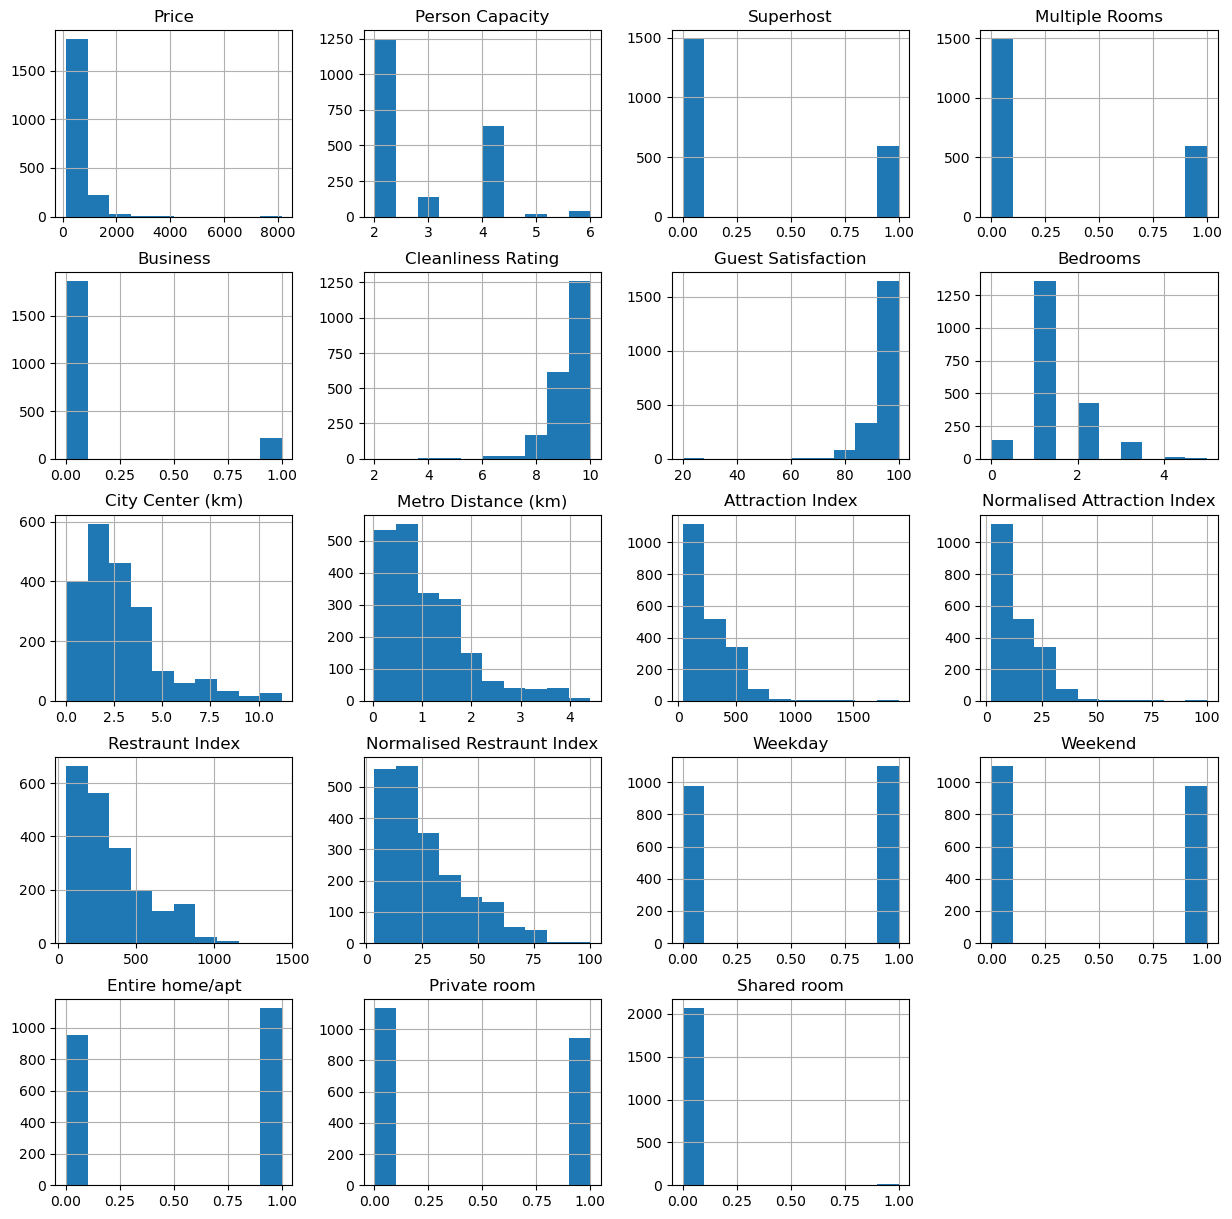

In [17]:
df.hist(figsize=(15,15))

Looking at the histogram above, we see that most of Shared room values are 0, therefore we'll drop the Shared room column.

We'll also drop Attraction Index and Restaurant Index columns since there are Normalised Attraction Index and Normalised Restaurant Index.

In [18]:
df.drop('Shared room', axis=1, inplace=True)
df.drop('Attraction Index', axis=1, inplace=True)
df.drop('Restraunt Index', axis=1, inplace=True)

array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Person Capacity'}>,
        <Axes: title={'center': 'Superhost'}>,
        <Axes: title={'center': 'Multiple Rooms'}>],
       [<Axes: title={'center': 'Business'}>,
        <Axes: title={'center': 'Cleanliness Rating'}>,
        <Axes: title={'center': 'Guest Satisfaction'}>,
        <Axes: title={'center': 'Bedrooms'}>],
       [<Axes: title={'center': 'City Center (km)'}>,
        <Axes: title={'center': 'Metro Distance (km)'}>,
        <Axes: title={'center': 'Normalised Attraction Index'}>,
        <Axes: title={'center': 'Normalised Restraunt Index'}>],
       [<Axes: title={'center': 'Weekday'}>,
        <Axes: title={'center': 'Weekend'}>,
        <Axes: title={'center': 'Entire home/apt'}>,
        <Axes: title={'center': 'Private room'}>]], dtype=object)

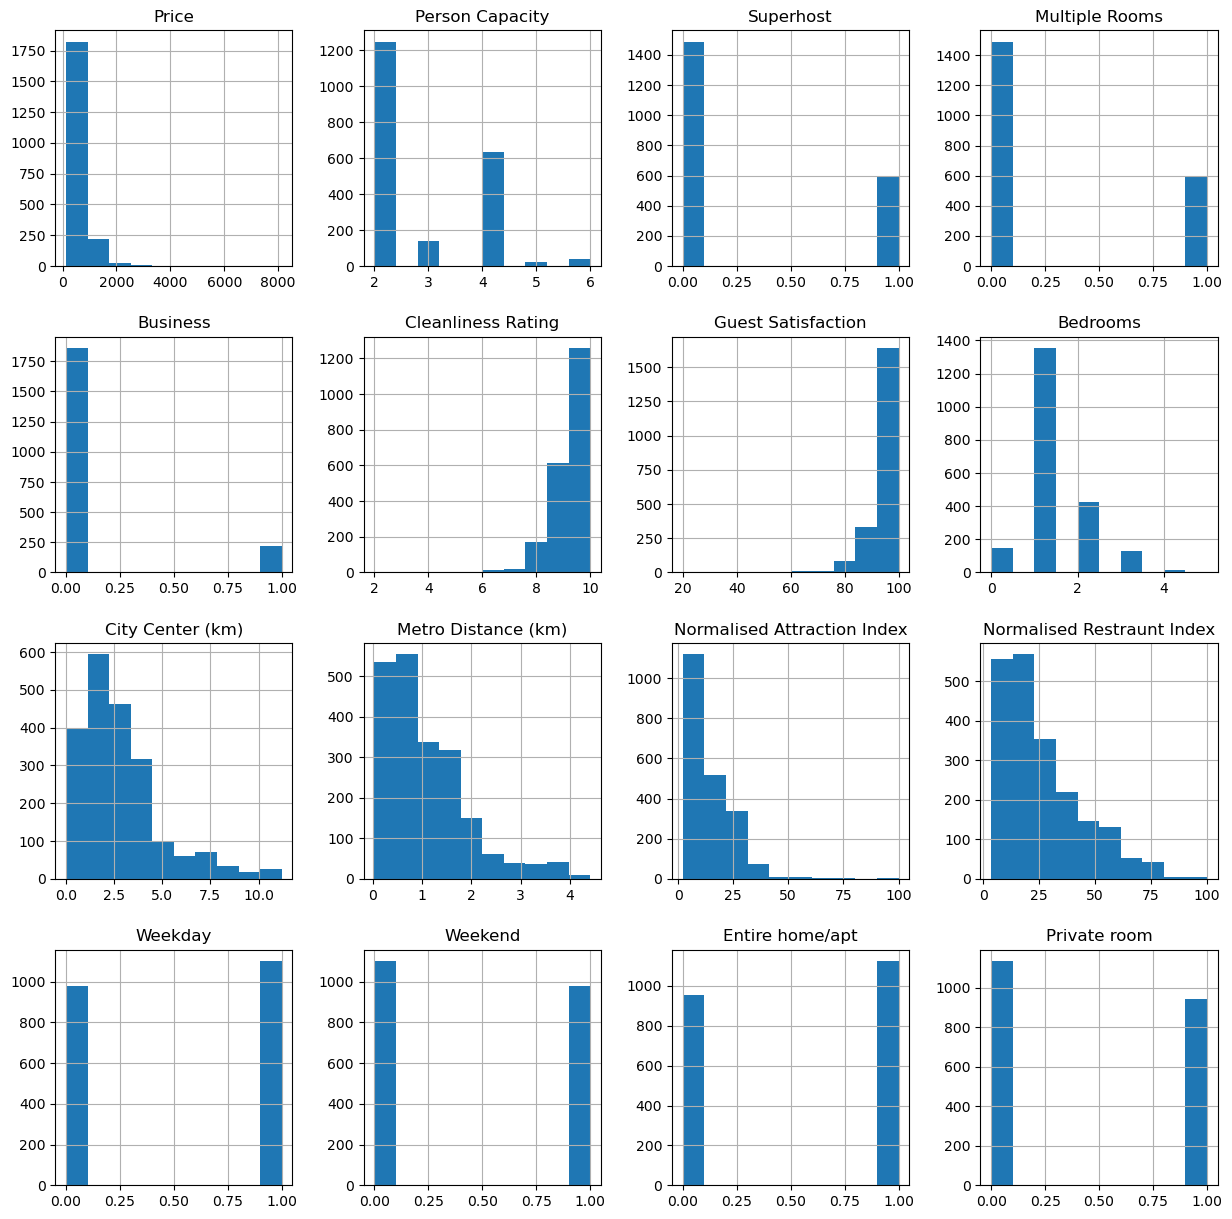

In [19]:
df.hist(figsize=(15,15))

Generating the correlation map, to see how strongly the attributes correlate

In [20]:
df.corr(numeric_only=True)

,Price,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,Bedrooms,City Center (km),Metro Distance (km),Normalised Attraction Index,Normalised Restraunt Index,Weekday,Weekend,Entire home/apt,Private room
Price,1.000000,0.527603,-0.049284,-0.095892,-0.021348,0.033699,0.130790,0.501503,-0.262208,-0.144473,0.254232,0.241558,-0.069326,0.069326,0.407728,-0.401520
Person Capacity,0.527603,1.000000,-0.059892,-0.121388,0.071010,-0.050677,0.038693,0.663091,-0.043164,-0.022271,0.061208,0.028752,0.010965,-0.010965,0.335299,-0.336690
Superhost,-0.049284,-0.059892,1.000000,0.084338,-0.111925,0.295821,0.268455,-0.053197,0.024222,0.021855,-0.015859,-0.018744,0.020504,-0.020504,-0.156034,0.153685
Multiple Rooms,-0.095892,-0.121388,0.084338,1.000000,-0.215609,0.011292,-0.045713,-0.097319,0.017894,-0.023142,-0.001001,0.033807,0.059141,-0.059141,-0.263093,0.256525
Business,-0.021348,0.071010,-0.111925,-0.215609,1.000000,-0.050128,-0.124254,-0.036188,-0.063255,-0.027745,0.104037,0.100520,0.034106,-0.034106,-0.099195,0.102592
Cleanliness Rating,0.033699,-0.050677,0.295821,0.011292,-0.050128,1.000000,0.657592,0.003013,-0.019225,0.013213,-0.011546,0.007039,-0.005745,0.005745,-0.001856,0.006202
Guest Satisfaction,0.130790,0.038693,0.268455,-0.045713,-0.124254,0.657592,1.000000,0.103552,-0.058317,0.033750,0.006388,0.002799,-0.025399,0.025399,0.153442,-0.150965
Bedrooms,0.501503,0.663091,-0.053197,-0.097319,-0.036188,0.003013,0.103552,1.000000,0.020562,-0.007024,-0.001244,-0.043071,-0.013623,0.013623,0.348286,-0.344749
City Center (km),-0.262208,-0.043164,0.024222,0.017894,-0.063255,-0.019225,-0.058317,0.020562,1.000000,0.399539,-0.691265,-0.742570,0.008456,-0.008456,-0.122037,0.114146
Metro Distance (km),-0.144473,-0.022271,0.021855,-0.023142,-0.027745,0.013213,0.033750,-0.007024,0.399539,1.000000,-0.451186,-0.469588,0.000092,-0.000092,-0.059398,0.057210


<Axes: >

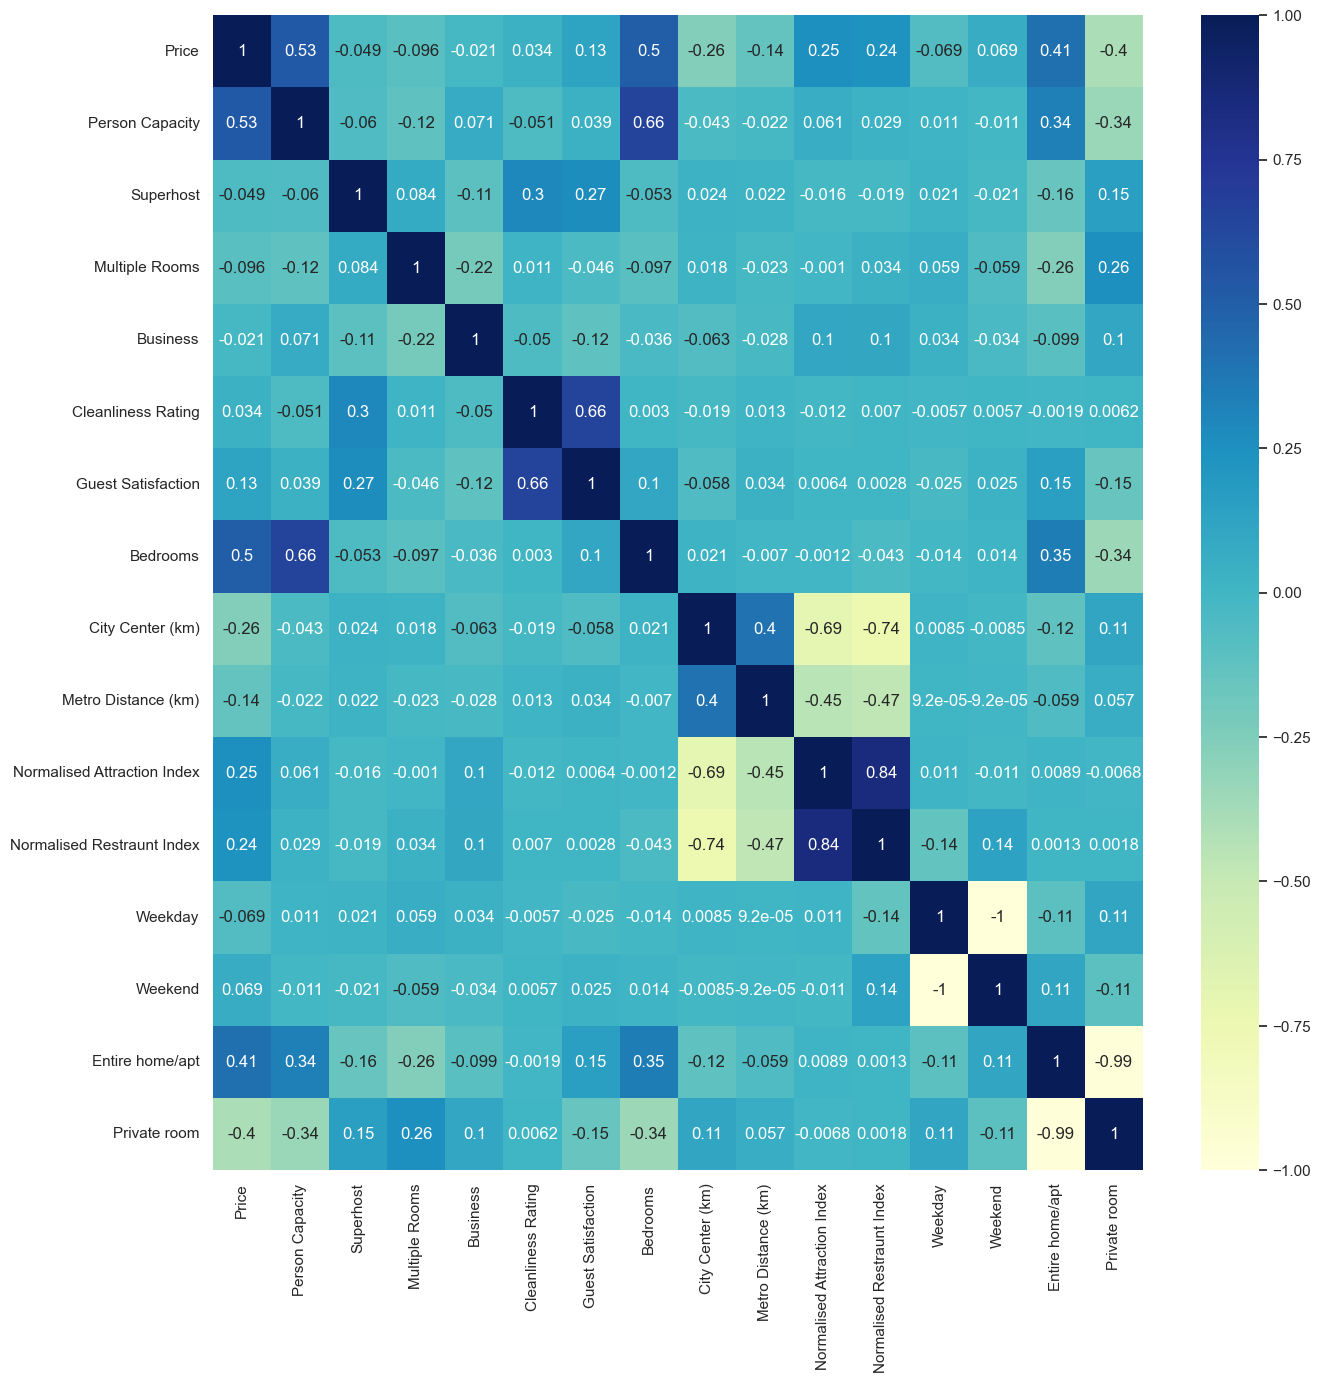

In [21]:
sns.set(rc = {'figure.figsize':(15, 15)})
sns.heatmap(df.corr(numeric_only=True), cmap='YlGnBu', annot=True)

From the above map, we see that the Person capacity, bedrooms, and Entire home are the most correlated with the price.

# Testing Regression Models

We will test 2 Regression models, Linear Regression Model, and Random Forest Regression Model, and see how they perform.

Since we're testing how the models perform to know which model to choose and for the sake of simplicity we will not differentiate between weekdays and weekends

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler

# Split the data for test and train sets
def split_test_train_set(data):
    x, y = data.drop('Price', axis=1), data['Price']
    scaler = StandardScaler()
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    x_train= scaler.fit_transform(x_train)
    # Scale the data
    x_test= scaler.transform(x_test)
    return x_train, x_test, y_train, y_test

## Linear Regression Model

In [23]:
x_train, x_test, y_train, y_test = split_test_train_set(df)

In [24]:
def testLinearRegression(x_train, x_test, y_train, y_test):
    reg = LinearRegression()
    # Train the model
    reg.fit(x_train, y_train)
    # Print the score
    print('Linear Regression score: ' + str(reg.score(x_test, y_test)))

In [25]:
testLinearRegression(x_train, x_test, y_train, y_test)

Linear Regression score: 0.3103242728976181


With Linear Regression Model we got low score

## Random Forest Regression Model

In [26]:
x_train, x_test, y_train, y_test = split_test_train_set(df)

def testRandomForestRegression(x_train, x_test, y_train, y_test):
    forest = RandomForestRegressor()
    # Train
    forest.fit(x_train, y_train)
    # print score
    print('Random Forest Regression score: ' + str(forest.score(x_test, y_test)))

In [27]:
testRandomForestRegression(x_train, x_test, y_train, y_test)

Random Forest Regression score: 0.727577583076931


With Random Forest Regression Model we've got a better score.
We'll try to use Grid Search, and see if the score improves.

## Grid Search Random Forest

In [28]:
from sklearn.model_selection import GridSearchCV

def testGridSearchRandomForest(x_train, x_test, y_train, y_test):
    # init
    forest = RandomForestRegressor()
    param_grid = {
    "n_estimators": [50, 100, 200, 300],
    "max_features": [4, 6, 8, 12, 16]
    }
    grid_search = GridSearchCV(forest, param_grid, cv=5,
                           scoring="neg_mean_squared_error", return_train_score=True)
    # Train
    grid_search.fit(x_train, y_train)
    
    # print result
    best_forest = grid_search.best_estimator_
    print(best_forest)
    
    # print score
    print('Grid Search Random Forest score: ' + str(best_forest.score(x_test, y_test)))

In [29]:
testGridSearchRandomForest(x_train, x_test, y_train, y_test)

RandomForestRegressor(max_features=6, n_estimators=200)
Grid Search Random Forest score: 0.6413469712696248


With Grid Search we've got slightly better score.

# Checking for Outliers

We will use the boxplot to check for outliers

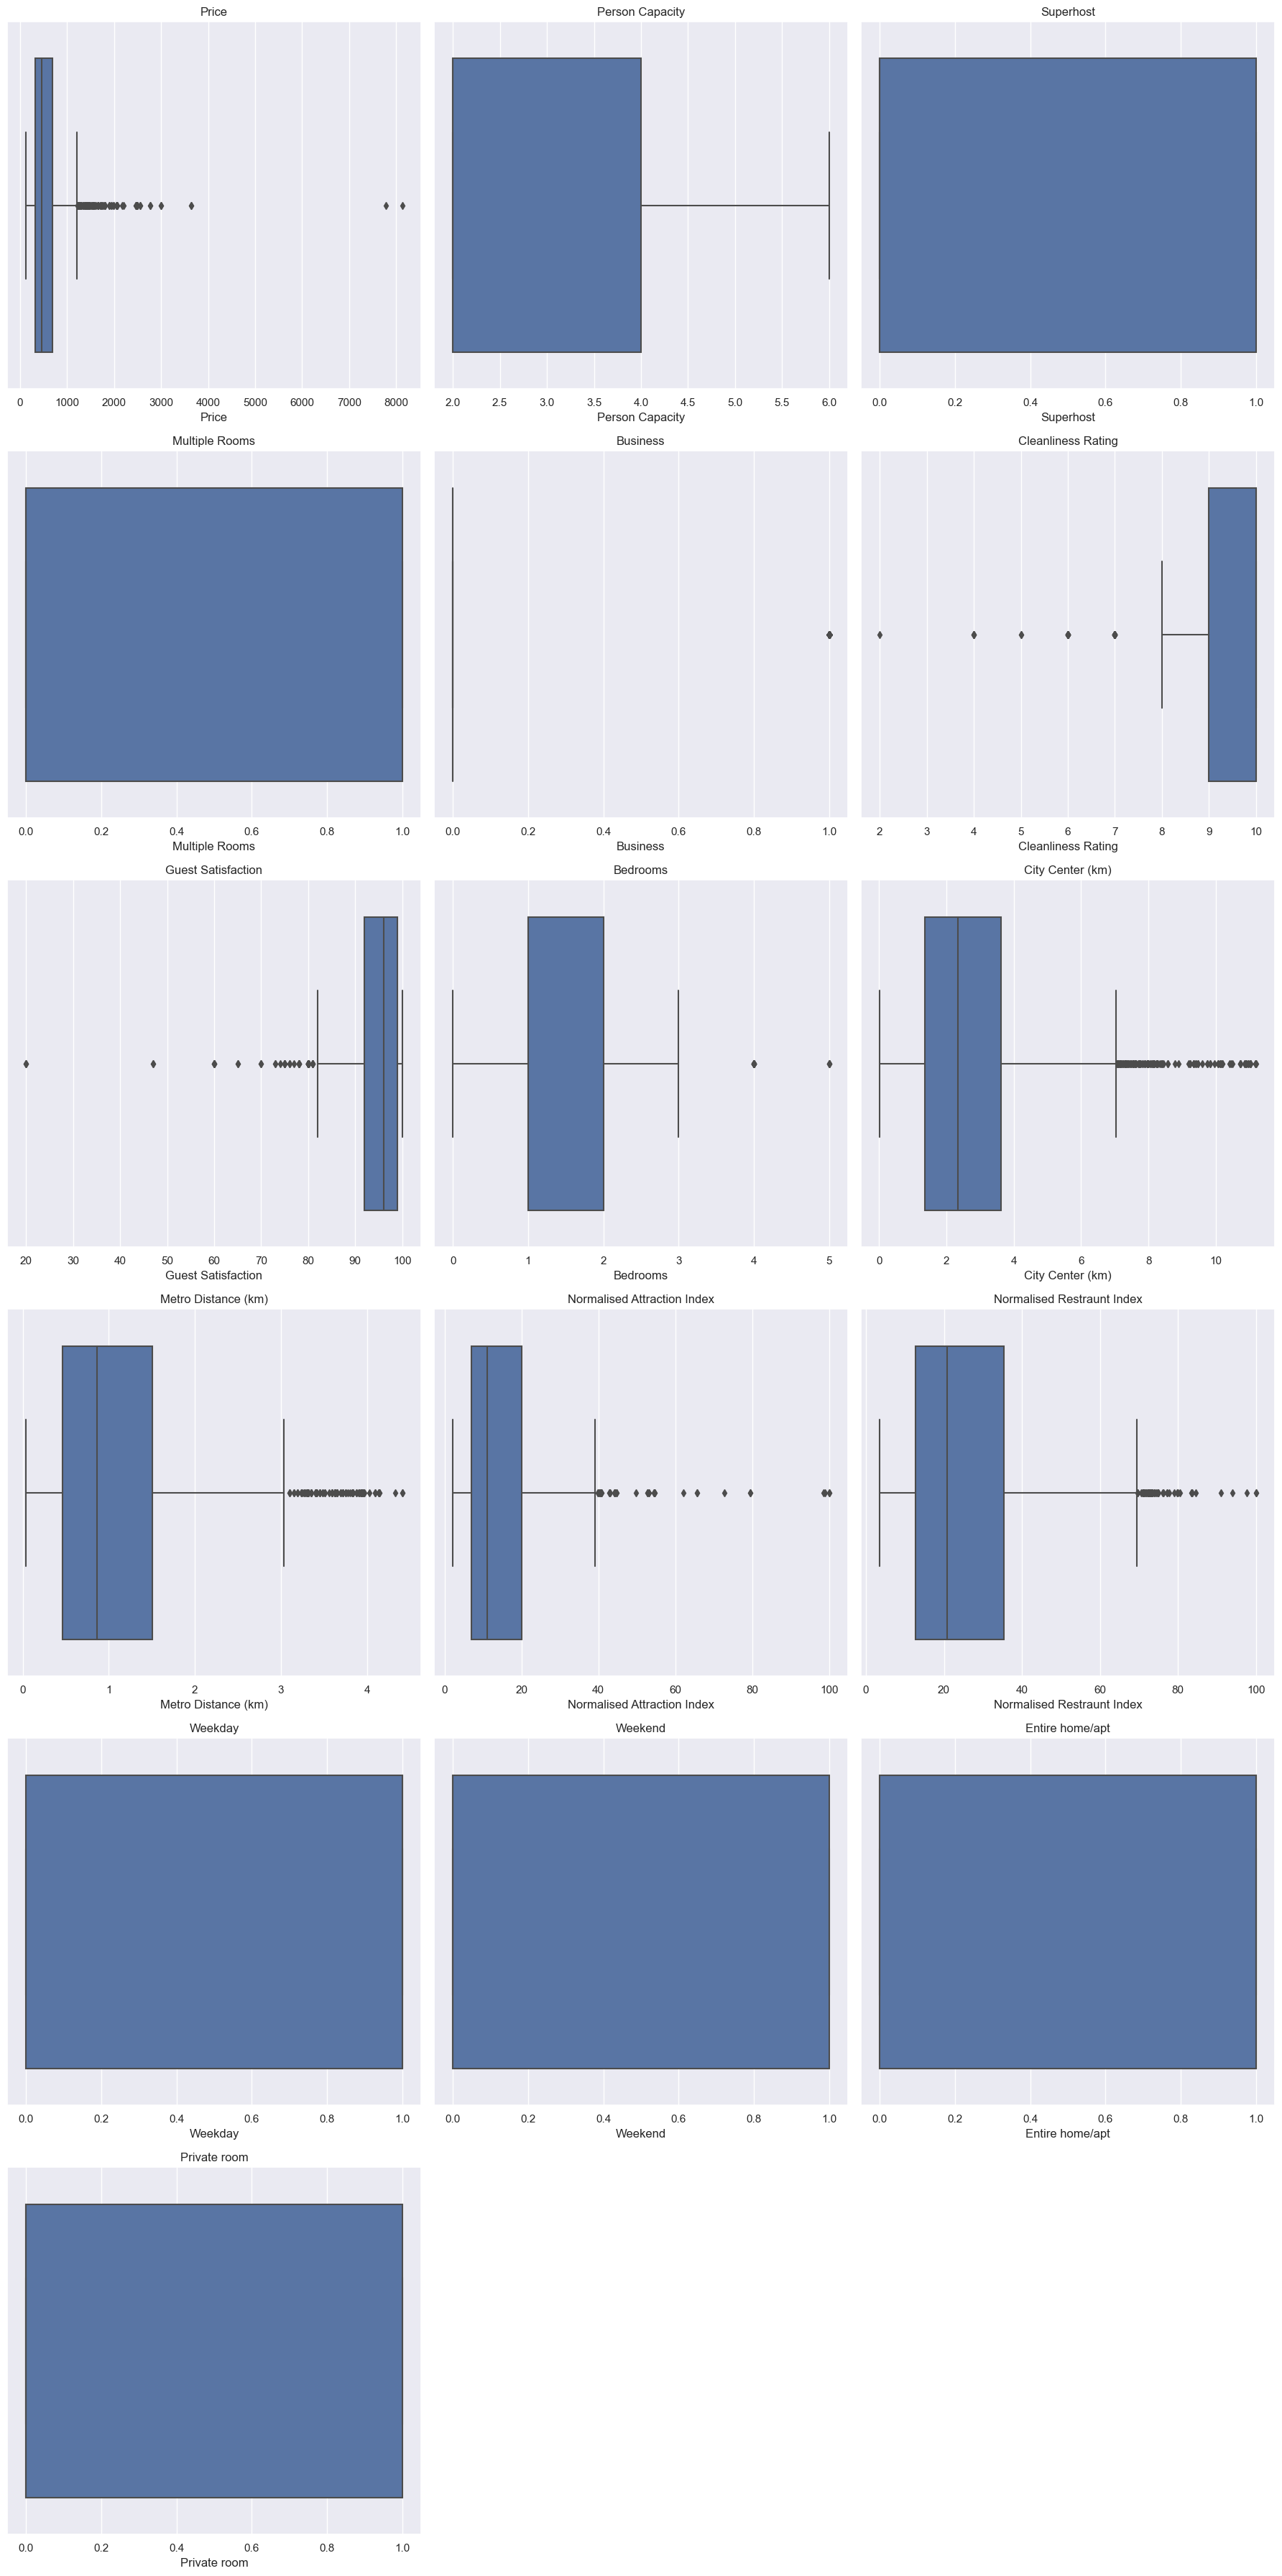

In [30]:
def plot_boxplots(data, columns):
    num_columns = len(columns)
    num_rows = (num_columns // 3) + (num_columns % 3 > 0)  # Calculate the number of rows needed
    num_cols = min(3, num_columns)  # Maximum 3 columns per row
    plt.figure(figsize=(18, 6 * num_rows))
    for i, col in enumerate(columns, start=1):
        plt.subplot(num_rows, num_cols, i)
        sns.boxplot(data=data, x=col, orient='h')
        plt.title(col)  # Add title to each subplot
        
    plt.tight_layout()
    plt.show()

# Get all numeric columns from the DataFrame
numeric_columns = df.select_dtypes(include='number').columns.tolist()

# Call the generalized function to plot boxplots
plot_boxplots(df, numeric_columns)

Here we see that there's a clearly outliers, we will remove the outliers from the traget column (the Price)

In [31]:
# Remove Outliers
def remove_outliers(data, col):
    d25 = data[col].quantile(0.25)
    d75 = data[col].quantile(0.75)
    diqr = d75 - d25
    upper_lim = d75 + 1.5 * diqr
    lower_lim = d25 - 1.5 * diqr
    filtered_data = data[(data[col] >= lower_lim) & (data[col] <= upper_lim)]
    return filtered_data

# Apply outlier removal to multiple columns
columns_to_remove_outliers = ['Price']
for col in columns_to_remove_outliers:
    df = remove_outliers(df, col)

In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1975 entries, 0 to 2079
Data columns (total 16 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Price                        1975 non-null   float64
 1   Person Capacity              1975 non-null   float64
 2   Superhost                    1975 non-null   int64  
 3   Multiple Rooms               1975 non-null   int64  
 4   Business                     1975 non-null   int64  
 5   Cleanliness Rating           1975 non-null   float64
 6   Guest Satisfaction           1975 non-null   float64
 7   Bedrooms                     1975 non-null   int64  
 8   City Center (km)             1975 non-null   float64
 9   Metro Distance (km)          1975 non-null   float64
 10  Normalised Attraction Index  1975 non-null   float64
 11  Normalised Restraunt Index   1975 non-null   float64
 12  Weekday                      1975 non-null   uint8  
 13  Weekend           

Testing the models after removing the outliers

In [33]:
x_train, x_test, y_train, y_test = split_test_train_set(df)

In [34]:
testLinearRegression(x_train, x_test, y_train, y_test)

Linear Regression score: 0.6430537083357015


In [35]:
testRandomForestRegression(x_train, x_test, y_train, y_test)

Random Forest Regression score: 0.7808495348152442


In [36]:
testGridSearchRandomForest(x_train, x_test, y_train, y_test)

RandomForestRegressor(max_features=6, n_estimators=200)
Grid Search Random Forest score: 0.7742598084015699


# Principal component analysis

Since we have a lot of attributes, we will try to reduce them with PCA (Principal component analysis)

In [70]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

scaler = StandardScaler()
att_df = df.copy().drop('Price', axis=1, inplace=False)
att_df.head()

,Person Capacity,Superhost,Multiple Rooms,Business,Cleanliness Rating,Guest Satisfaction,Bedrooms,City Center (km),Metro Distance (km),Normalised Attraction Index,Normalised Restraunt Index,Weekday,Weekend,Entire home/apt,Private room
0,2.0,0,1,0,10.0,93.0,1,5.022964,2.539380,4.166708,6.846473,1,0,0,1
1,4.0,0,0,0,8.0,85.0,1,0.488389,0.239404,33.421209,58.342928,1,0,0,1
2,2.0,0,0,1,9.0,87.0,1,5.748312,3.651621,3.985908,6.646700,1,0,0,1
3,4.0,0,0,1,9.0,90.0,2,0.384862,0.439876,26.119108,60.973565,1,0,0,1
4,2.0,1,0,0,10.0,98.0,1,0.544738,0.318693,29.272733,56.811677,1,0,0,1


In [78]:
scaler.fit(att_df)
scaled_data = scaler.transform(att_df)

In [79]:
pca = PCA(n_components=2)
pca.fit(scaled_data)

PCA(n_components=2)

In [80]:
x_pca = pca.transform(scaled_data)

In [81]:
x_pca.shape

(1975, 2)

Text(0, 0.5, 'Second PC')

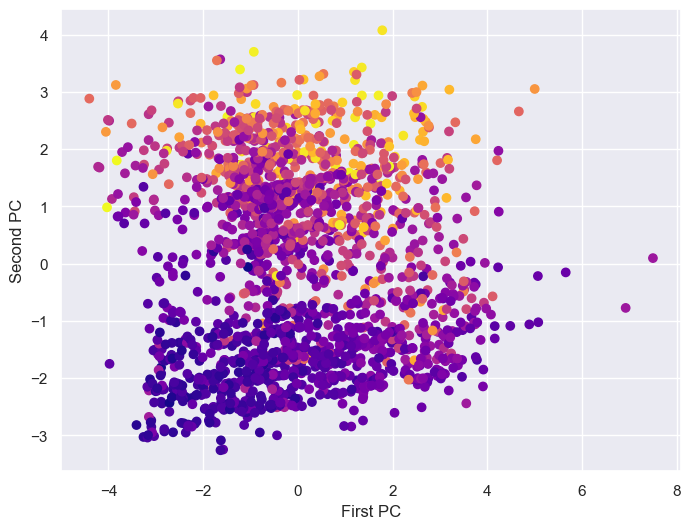

In [83]:
plt.figure(figsize=(8,6))
plt.scatter(x_pca[:,0],x_pca[:,1], c=df['Price'], cmap='plasma')
plt.xlabel('First PC')
plt.ylabel('Second PC')

Test the models after PCA

In [84]:
x_pca

array([[-1.96642744, -2.53866958],
       [ 3.06695719, -0.60904115],
       [-2.38611233, -2.31821122],
       ...,
       [-0.14184632,  2.29853807],
       [-0.61636494,  1.12462807],
       [ 1.46647066,  2.59777297]])

In [85]:
def split_test_train_set_for_pca(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    # Scale the data
#     scaler = StandardScaler()
#     x_train= scaler.fit_transform(x_train)
#     x_test= scaler.transform(x_test)
    return x_train, x_test, y_train, y_test

In [86]:
x_train, x_test, y_train, y_test = split_test_train_set_for_pca(x_pca, df['Price'])

In [87]:
testLinearRegression(x_train, x_test, y_train, y_test)

Linear Regression score: 0.5282277582017876


In [88]:
testRandomForestRegression(x_train, x_test, y_train, y_test)

Random Forest Regression score: 0.48746607177974477


In [89]:
testGridSearchRandomForest(x_train, x_test, y_train, y_test)

RandomForestRegressor(max_features=16, n_estimators=300)
Grid Search Random Forest score: 0.4977211211362317


# M2 Model - Real Estate Dataset

The M2 model will estimate the price of the property depending on its features.

<a href="https://www.kaggle.com/datasets/thomasnibb/amsterdam-house-price-prediction">Link to Amsterdam House Prices Dataset</a>

## Exploring The Dataset

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Read the airbnb dataset
dfM2 = pd.read_csv('datasets/housing-prices-amsterdam-august-2021.csv')
dfM2.head()

,Unnamed: 0,Address,Zip,Price,Area,Room,Lon,Lat
0,1,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157
1,2,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586
2,3,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782
3,4,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712
4,5,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538


## Data Preparation

As we see, there is Unamed:0 index column, we'll drop it

In [24]:
dfM2.drop('Unnamed: 0', axis=1, inplace=True)
dfM2.head()

,Address,Zip,Price,Area,Room,Lon,Lat
0,"Blasiusstraat 8 2, Amsterdam",1091 CR,685000.0,64,3,4.907736,52.356157
1,"Kromme Leimuidenstraat 13 H, Amsterdam",1059 EL,475000.0,60,3,4.850476,52.348586
2,"Zaaiersweg 11 A, Amsterdam",1097 SM,850000.0,109,4,4.944774,52.343782
3,"Tenerifestraat 40, Amsterdam",1060 TH,580000.0,128,6,4.789928,52.343712
4,"Winterjanpad 21, Amsterdam",1036 KN,720000.0,138,5,4.902503,52.410538


In [25]:
dfM2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 924 entries, 0 to 923
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Address  924 non-null    object 
 1   Zip      924 non-null    object 
 2   Price    920 non-null    float64
 3   Area     924 non-null    int64  
 4   Room     924 non-null    int64  
 5   Lon      924 non-null    float64
 6   Lat      924 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 50.7+ KB


In [26]:
dfM2['Price'].info()

<class 'pandas.core.series.Series'>
RangeIndex: 924 entries, 0 to 923
Series name: Price
Non-Null Count  Dtype  
--------------  -----  
920 non-null    float64
dtypes: float64(1)
memory usage: 7.3 KB


We see that we have some NaN values (4 values), we'll drop them.

In [27]:
# Check NaN raws
print(dfM2[dfM2['Price'].isna()])

                          Address      Zip  Price  Area  Room       Lon  \
73    Falckstraat 47 A, Amsterdam  1017 VV    NaN   147     3  4.897454   
321  Haarlemmerweg 705, Amsterdam  1067 HP    NaN   366    12  4.787874   
610  Zeeburgerkade 760, Amsterdam  1019 HT    NaN   107     3  4.945022   
727     Suikerplein 16, Amsterdam  1013 CK    NaN    81     3  4.880976   

           Lat  
73   52.360707  
321  52.383877  
610  52.369244  
727  52.389623  


In [28]:
# Drop NaN raws
dfM2.dropna(inplace=True)
print(dfM2[dfM2['Price'].isna()])

Empty DataFrame
Columns: [Address, Zip, Price, Area, Room, Lon, Lat]
Index: []


In [29]:
dfM2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 920 entries, 0 to 923
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Address  920 non-null    object 
 1   Zip      920 non-null    object 
 2   Price    920 non-null    float64
 3   Area     920 non-null    int64  
 4   Room     920 non-null    int64  
 5   Lon      920 non-null    float64
 6   Lat      920 non-null    float64
dtypes: float64(3), int64(2), object(2)
memory usage: 57.5+ KB


## Data Visualization

<Axes: >

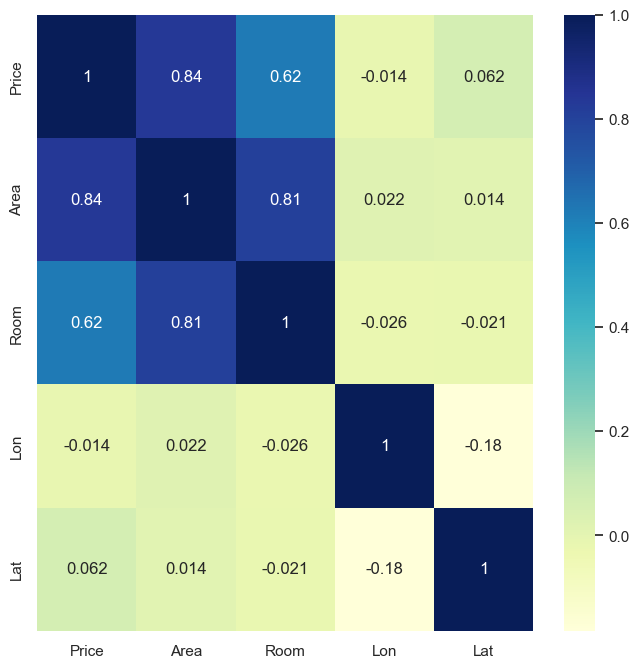

In [30]:
sns.set(rc = {'figure.figsize':(8,8)})
sns.heatmap(dfM2.corr(numeric_only=True), cmap='YlGnBu', annot=True)

From the above map, we see that the Area, and Room are highly correlated with the price.

array([[<Axes: title={'center': 'Price'}>,
        <Axes: title={'center': 'Area'}>],
       [<Axes: title={'center': 'Room'}>,
        <Axes: title={'center': 'Lon'}>],
       [<Axes: title={'center': 'Lat'}>, <Axes: >]], dtype=object)

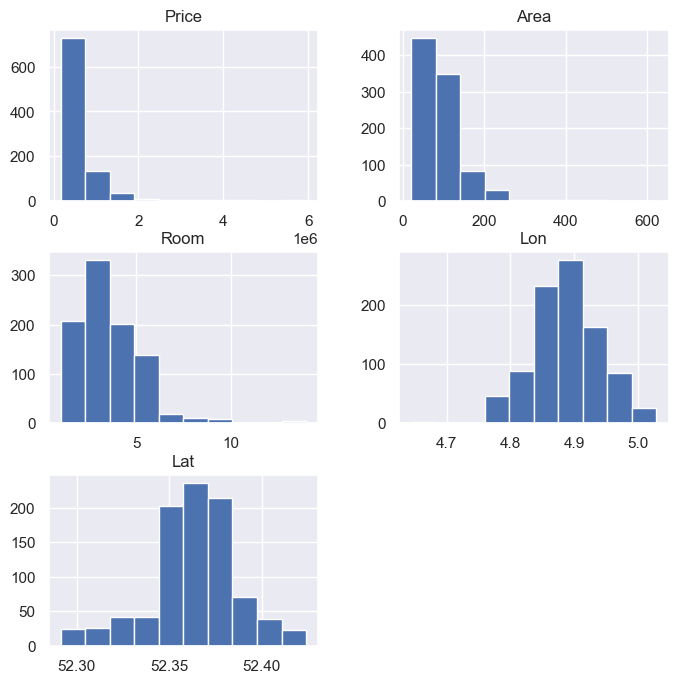

In [31]:
dfM2.hist()

## Testing Regression Models

We will test 2 Regression models, Linear Regression Model, and Random Forest Regression Model, and see how they perform.

Since we're testing how the models perform to know which model to choose and for the sake of simplicity we will drop the Address and Zip column

In [32]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

# drop Address and Zip
dfM2.drop('Address', axis=1, inplace=True)
dfM2.drop('Zip', axis=1, inplace=True)

x_train, x_test, y_train, y_test = split_test_train_set(dfM2)

## Linear Regression Model

In [33]:
reg = LinearRegression()

reg.fit(x_train, y_train)

LinearRegression()

In [34]:
reg.score(x_test, y_test)

0.6857485407582775

We got good score with Linear Regression Model

## Random Forest Regression Model

In [35]:
from sklearn.ensemble import RandomForestRegressor

forest = RandomForestRegressor()

forest.fit(x_train, y_train)

RandomForestRegressor()

In [36]:
forest.score(x_test, y_test)

0.7959610422139698

With Random Forest Regression Model we've got a better score. We'll try to use Grid Search, and see if the score improves.

In [49]:
from sklearn.model_selection import GridSearchCV

forest = RandomForestRegressor()

param_grid = {
    "n_estimators": [100, 200, 300, 400],
    "max_features": [2, 3, 4]
}

grid_search = GridSearchCV(forest, param_grid, cv=5,
                           scoring="neg_mean_squared_error", return_train_score=True)

grid_search.fit(x_train, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_features': [2, 3, 4],
                         'n_estimators': [100, 200, 300, 400]},
             return_train_score=True, scoring='neg_mean_squared_error')

In [50]:
best_forest = grid_search.best_estimator_
best_forest

RandomForestRegressor(max_features=2, n_estimators=200)

Best forest we got with max_features=2, n_estimators=200

In [51]:
best_forest.score(x_test, y_test)

0.8087142045940471

Here we see again that with Random Forest Regression Model we got better score